**Import data from Kaggle**

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!kaggle competitions download -c auto-insurance-fall-2017

  0% 0.00/326k [00:00<?, ?B/s]
100% 326k/326k [00:00<00:00, 75.1MB/s]


In [ ]:
!unzip '/content/auto-insurance-fall-2017.zip'

Archive:  /content/auto-insurance-fall-2017.zip
  inflating: MEAN_AUTO.csv           
  inflating: SHELL_AUTO.csv          
  inflating: test_auto.csv           
  inflating: train_auto.csv          


**Data preprocessing**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics

In [ ]:
# Import train data and test data at the same time for the preprocessing of feature data
df1 = pd.read_csv('/content/train_auto.csv', index_col=0)
df2 = pd.read_csv('/content/test_auto.csv', index_col=0)
df = df1.append(df2)
print(df.shape)
df.head()

(10302, 25)


,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,0.0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,0.0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,0.0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,0.0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [ ]:
# Drop the columns ['TARGET_FLAG','TARGET_AMT'] to make a dataframe of all feature data and make an array of 'TARGET_FLAG' data
X_df = df.drop(columns=['TARGET_FLAG','TARGET_AMT'])
y = df['TARGET_FLAG'].values
# Check how many NA values are in X_df
X_df.isnull().sum()

KIDSDRIV        0
AGE             7
HOMEKIDS        0
YOJ           548
INCOME        570
PARENT1         0
HOME_VAL      575
MSTATUS         0
SEX             0
EDUCATION       0
JOB           665
TRAVTIME        0
CAR_USE         0
BLUEBOOK        0
TIF             0
CAR_TYPE        0
RED_CAR         0
OLDCLAIM        0
CLM_FREQ        0
REVOKED         0
MVR_PTS         0
CAR_AGE       639
URBANICITY      0
dtype: int64

In [ ]:
# Check the unique values of X_df to see how categories or different values are in each column
for col in X_df.columns:
    print(col, ":", X_df[col].unique().shape[0])

KIDSDRIV : 5
AGE : 62
HOMEKIDS : 6
YOJ : 22
INCOME : 8152
PARENT1 : 2
HOME_VAL : 6335
MSTATUS : 2
SEX : 2
EDUCATION : 5
JOB : 9
TRAVTIME : 100
CAR_USE : 2
BLUEBOOK : 2985
TIF : 23
CAR_TYPE : 6
RED_CAR : 2
OLDCLAIM : 3545
CLM_FREQ : 6
REVOKED : 2
MVR_PTS : 14
CAR_AGE : 31
URBANICITY : 2


In [ ]:
# Use (0,1) label to encode categorical features that only have 2 categories
X_df.PARENT1 = LabelEncoder().fit_transform(X_df.PARENT1)
X_df.MSTATUS = LabelEncoder().fit_transform(X_df.MSTATUS)
X_df.SEX = LabelEncoder().fit_transform(X_df.SEX)
X_df.CAR_USE = LabelEncoder().fit_transform(X_df.CAR_USE)
X_df.RED_CAR = LabelEncoder().fit_transform(X_df.RED_CAR)
X_df.REVOKED = LabelEncoder().fit_transform(X_df.REVOKED)
X_df.URBANICITY = LabelEncoder().fit_transform(X_df.URBANICITY)

In [ ]:
# Use Ordinal Encoding for categorical features that have ordinal nature
EDUCATION_dict = { '<High School': 0,
                  'z_High School': 1,
                  'Bachelors': 2,
                  'Masters': 3,
                  'PhD': 4}
X_df['EDUCATION'] = X_df.EDUCATION.map(EDUCATION_dict)

In [ ]:
# Fill NA values of the categorical feature 'JOB' with 'Unknown'
X_df['JOB'] = X_df['JOB'].fillna('Unknown')
# Use One Hot Encoding for categorical features that have no ordinal nature
X_df = pd.get_dummies(X_df, prefix = ['JOB'], columns = ['JOB'])
X_df = pd.get_dummies(X_df, prefix = ['CAR'], columns = ['CAR_TYPE'])

In [ ]:
# Convert columns with $ sign from string to float
X_df['INCOME'] = X_df['INCOME'].replace('[\$,]', '', regex=True).astype(float)
X_df['OLDCLAIM'] = X_df['OLDCLAIM'].replace('[\$,]', '', regex=True).astype(float)
X_df['HOME_VAL'] = X_df['HOME_VAL'].replace('[\$,]', '', regex=True).astype(float)
X_df['BLUEBOOK'] = X_df['BLUEBOOK'].replace('[\$,]', '', regex=True).astype(float)

In [ ]:
# As it is possible that there are NA values in test data, here I use imputation for missing data instead of just dropping them.
X_df_imputed = pd.DataFrame(SimpleImputer().fit_transform(X_df))
X_df_imputed.columns = X_df.columns
X_df_imputed.index = X_df.index

In [ ]:
# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the non-binary numeric columns 
numeric_vars = ['KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME','HOME_VAL', 'EDUCATION', 'TRAVTIME', 'BLUEBOOK', 'TIF', 'OLDCLAIM', 'CLM_FREQ', 'MVR_PTS', 'CAR_AGE']
X_df_imputed[numeric_vars] = scaler.fit_transform(X_df_imputed[numeric_vars])
X_df_imputed.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,...,JOB_Professional,JOB_Student,JOB_Unknown,JOB_z_Blue Collar,CAR_Minivan,CAR_Panel Truck,CAR_Pickup,CAR_Sports Car,CAR_Van,CAR_z_SUV
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.676923,0.0,0.478261,0.183497,0.0,0.000000,1.0,0.0,1.00,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.415385,0.0,0.478261,0.249159,0.0,0.290588,1.0,0.0,0.25,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.292308,0.2,0.434783,0.043699,0.0,0.140284,0.0,1.0,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.538462,0.0,0.608696,0.167758,0.0,0.345936,0.0,0.0,0.00,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.523077,0.0,0.455394,0.313288,0.0,0.275534,0.0,1.0,1.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Check if there are two columns that are highly correlated, so that they can be safely dropped.
# As a result, no two columns are highly correlated (>0.9).
corr = X_df_imputed.corr()
corr.style.background_gradient(cmap='coolwarm')

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY,JOB_Clerical,JOB_Doctor,JOB_Home Maker,JOB_Lawyer,JOB_Manager,JOB_Professional,JOB_Student,JOB_Unknown,JOB_z_Blue Collar,CAR_Minivan,CAR_Panel Truck,CAR_Pickup,CAR_Sports Car,CAR_Van,CAR_z_SUV
KIDSDRIV,1.000000,-0.078424,0.463653,0.041668,-0.041918,0.200157,-0.015124,-0.041655,0.039712,-0.075693,0.012207,0.004146,-0.028508,-0.005830,-0.040508,0.023886,0.038952,0.033639,0.048424,-0.057183,0.043622,0.037576,-0.038983,0.005098,-0.033550,-0.015689,-0.019169,0.025676,-0.035546,0.036273,-0.004824,-0.015580,-0.002020,0.002053,-0.028154,0.032421
AGE,-0.078424,1.000000,-0.447502,0.136625,0.181167,-0.310917,0.203858,-0.086941,-0.069553,0.248948,-0.001568,0.027237,0.166191,-0.001889,0.025859,-0.033366,-0.037622,-0.045033,-0.075685,0.173325,-0.042454,-0.152151,0.120929,-0.003756,0.136087,0.094985,0.037181,-0.116111,0.045601,-0.067726,0.004773,0.057799,-0.032704,0.023329,0.028219,-0.047139
HOMEKIDS,0.463653,-0.447502,1.000000,0.075582,-0.155777,0.448719,-0.104638,-0.045968,0.113403,-0.205273,-0.000722,0.011858,-0.108569,0.007509,-0.068117,0.029756,0.038661,0.044181,0.064294,-0.153952,0.061663,0.123598,-0.077706,0.020832,-0.100192,-0.078268,-0.055790,0.125195,-0.059484,0.041554,-0.033416,-0.064541,-0.007978,0.043321,-0.046486,0.077862
YOJ,0.041668,0.136625,0.075582,1.000000,0.277788,-0.038150,0.257883,-0.136939,-0.077391,0.089938,-0.016703,-0.025237,0.144197,0.023304,0.050588,-0.004960,-0.022908,-0.009699,-0.040493,0.060922,-0.076671,0.099291,0.036816,-0.329662,0.077838,0.073655,0.081257,-0.317853,0.053534,0.118524,0.046932,0.044660,0.003338,-0.061242,0.039018,-0.057532
INCOME,-0.041918,0.181167,-0.155777,0.277788,1.000000,-0.065415,0.545921,0.034711,-0.110933,0.585856,-0.050224,-0.087051,0.417944,0.002301,0.064740,-0.038255,-0.047940,-0.022329,-0.062025,0.392771,-0.195018,-0.244153,0.246986,-0.296409,0.184689,0.203244,0.117162,-0.344392,0.300121,-0.029369,0.038818,0.219289,-0.056621,-0.101913,0.123218,-0.131057
PARENT1,0.200157,-0.310917,0.448719,-0.038150,-0.065415,1.000000,-0.243773,0.474844,0.068894,-0.083224,-0.015810,-0.002424,-0.049512,0.009043,-0.044500,0.039312,0.061613,0.050676,0.070142,-0.064084,0.022215,0.054042,-0.039568,-0.006201,-0.044578,-0.027187,-0.007177,0.048832,-0.030141,0.017846,-0.016531,-0.032639,-0.003058,0.023819,-0.027346,0.039278
HOME_VAL,-0.015124,0.203858,-0.104638,0.257883,0.545921,-0.243773,1.000000,-0.441037,-0.076923,0.339254,-0.034268,-0.032900,0.254146,0.006559,0.029700,-0.058306,-0.091304,-0.043607,-0.089604,0.210079,-0.113569,-0.123090,0.131390,-0.152154,0.115468,0.136092,0.101363,-0.321902,0.138938,0.014530,0.025047,0.130043,-0.032903,-0.059220,0.071749,-0.080294
MSTATUS,-0.041655,-0.086941,-0.045968,-0.136939,0.034711,0.474844,-0.441037,1.000000,-0.000930,0.043057,-0.006010,-0.011879,0.007260,0.006839,0.013803,0.044617,0.070560,0.040777,0.050898,0.034114,-0.006642,-0.019722,0.032866,-0.005527,0.007450,-0.006643,0.003883,-0.005623,0.025357,-0.007481,0.003237,0.010330,-0.006633,-0.011095,0.007785,-0.001014
SEX,0.039712,-0.069553,0.113403,-0.077391,-0.110933,0.068894,-0.076923,-0.000930,1.000000,-0.041325,0.010539,0.282008,-0.062378,0.007191,-0.663209,0.004155,-0.014001,0.011450,0.011111,-0.024806,0.046028,0.011959,0.021542,0.245963,0.032485,-0.037224,-0.042427,0.002841,-0.174266,-0.039585,-0.237499,-0.296127,-0.212964,0.314621,-0.258447,0.534447
EDUCATION,-0.075693,0.248948,-0.205273,0.089938,0.585856,-0.083224,0.339254,0.043057,-0.041325,1.000000,-0.053723,0.034905,0.283591,-0.000216,0.022471,-0.021227,-0.019033,-0.017217,-0.049061,0.672332,-0.228093,-0.358041,0.333076,-0.034237,0.362406,0.206634,0.067889,-0.241067,0.346337,-0.326999,0.030693,0.139489,-0.066474,-0.040455,0.072173,-0.076974


In [ ]:
# Split the combined data into the original train data (train_auto) and test data (test_auto)
X_df_train_auto = X_df_imputed[:8161]
X_df_test_auto = X_df_imputed[8161:]
y_train_auto = y[:8161]

# Apply train-test 80-20 split for the original train data (train_auto)
X_train, X_test, y_train, y_test = train_test_split(X_df_train_auto, y_train_auto, test_size=0.2, random_state=0)

**Hyperparameter Tuning Using Grid Search Cross-Validation (Logistic Regression)**

In [ ]:
# Number of features in X_train
len(X_train.columns)

36

In [ ]:
# step-1: Create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: Specify range of hyperparameters (here is number of features to choose) to tune
hyper_params = [{'n_features_to_select': list(range(1, 37))}]

# step-3: Perform grid search
# 3.1 Specify model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
rfe = RFE(logreg)             

# 3.2 Call GridSearchCV() and set the scoring to "roc_auc" as it is a binary classification
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring = 'roc_auc',
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# Fit the model
model_cv.fit(X_train, y_train)   
print('The optimal number of features is:' + str(model_cv.best_estimator_.n_features_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
The optimal number of features is:26


In [ ]:
# CV results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.473875,0.058950,0.004835,0.000105,1,{'n_features_to_select': 1},0.643794,0.591098,0.632517,0.602681,...,0.614030,0.020384,36,0.603295,0.616887,0.615315,0.613601,0.614338,0.612687,0.004823
1,1.447862,0.033027,0.005011,0.000254,2,{'n_features_to_select': 2},0.651988,0.641597,0.678372,0.643247,...,0.656714,0.014402,35,0.614154,0.669213,0.658916,0.667781,0.662130,0.654439,0.020486
2,1.431591,0.051233,0.004892,0.000092,3,{'n_features_to_select': 3},0.729750,0.716002,0.677384,0.714545,...,0.712989,0.018782,34,0.720019,0.732587,0.668375,0.732206,0.729438,0.716525,0.024500
3,1.420746,0.057205,0.004831,0.000055,4,{'n_features_to_select': 4},0.741843,0.723774,0.749143,0.717746,...,0.732951,0.011464,33,0.737825,0.740966,0.734051,0.743617,0.738364,0.738965,0.003208
4,1.410836,0.027159,0.005148,0.000308,5,{'n_features_to_select': 5},0.748016,0.729318,0.752707,0.722496,...,0.738624,0.011288,32,0.747910,0.747432,0.741300,0.750602,0.747340,0.746917,0.003051
5,1.386806,0.054073,0.005029,0.000193,6,{'n_features_to_select': 6},0.756198,0.744547,0.762509,0.733595,...,0.749104,0.009915,31,0.752874,0.753601,0.749183,0.756033,0.752489,0.752836,0.002203
6,1.363824,0.070686,0.004999,0.000156,7,{'n_features_to_select': 7},0.760994,0.746585,0.769453,0.748555,...,0.755217,0.008686,30,0.754818,0.758418,0.752823,0.767794,0.757272,0.758225,0.005163
7,1.362775,0.056733,0.004975,0.000190,8,{'n_features_to_select': 8},0.762968,0.757411,0.784003,0.754676,...,0.763726,0.010495,29,0.759110,0.769635,0.763546,0.770467,0.769117,0.766375,0.004374
8,1.306084,0.034272,0.005399,0.000572,9,{'n_features_to_select': 9},0.762259,0.774765,0.795645,0.763627,...,0.773533,0.012003,28,0.765449,0.788780,0.770205,0.778253,0.789963,0.778530,0.009760
9,1.285082,0.050559,0.005007,0.000209,10,{'n_features_to_select': 10},0.769970,0.777163,0.809126,0.776756,...,0.781838,0.013894,27,0.775789,0.794744,0.783696,0.791888,0.793279,0.787879,0.007156


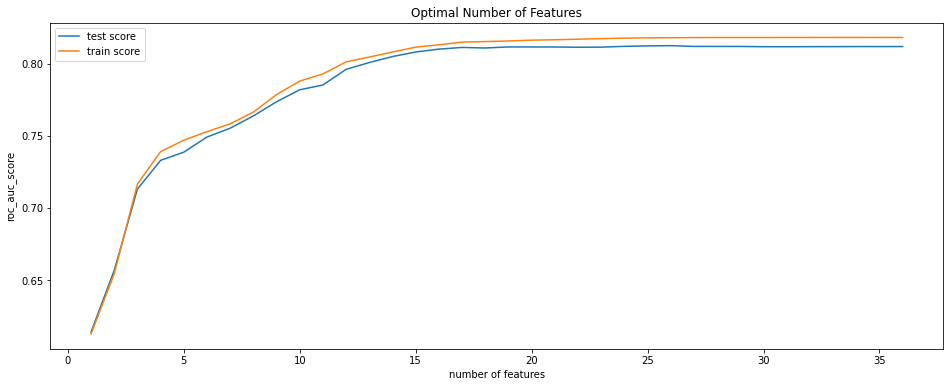

In [ ]:
# Plot cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('roc_auc_score')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [205]:
# Final model
# Based on the result of grid search cv, it's optimal to select 26 features out of 36 
n_features_optimal = 26

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

rfe = RFE(logreg, n_features_to_select=n_features_optimal)             
model1 = rfe.fit(X_train, y_train)

# Predict labels for X_test
y_pred = model1.predict(X_test)

# Print the performance of the model with different metrics
f1_score = sklearn.metrics.f1_score(y_test, y_pred)
roc_auc_score = sklearn.metrics.roc_auc_score(y_test, y_pred)
accuracy_score = sklearn.metrics.accuracy_score(y_test, y_pred)
print("f1_score for the model is {:.3f}".format(f1_score))
print("roc_auc_score for the model is {:.3f}".format(roc_auc_score))
print("accuracy_score for the model is {:.3f}".format(accuracy_score))

f1_score for the model is 0.517
roc_auc_score for the model is 0.674
accuracy_score for the model is 0.785


**Predict probabilities of target label for test data (Logistic Regression)**

In [ ]:
# Predict probabilities of target label for data in test_auto.csv, whihch is transformed in X_df_test_auto
y_pred = model1.predict_proba(X_df_test_auto)

In [ ]:
# Create a dataframe with the prediction result for submission
result_dict = {'INDEX': X_df_test_auto.index.values,
               'p_target': y_pred[:,1]}
result_df_lr = pd.DataFrame(result_dict)

In [ ]:
# Write the result to .csv file for submission
result_df_lr.to_csv('result_lr.csv',index=False)

**Hyperparameter Tuning Using Randomized Search Cross-Validation (Random Forest)**

In [ ]:
# As the training for Random Forest is more resource-consuming than Logistic Regression, here I use RandomizedSearchCV instead of GridSearchCV
# RFECV is added into RandomizedSearchCV for the process of Recursive Feature Elimination
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

hyper_params = {"estimator__max_depth": [3, None],
        "estimator__min_samples_split": sp_randint(2, 11),
        "estimator__min_samples_leaf": sp_randint(2, 11)}

estimator = RandomForestClassifier()
selector = RFECV(estimator, step=1, cv=5)
model2_cv = RandomizedSearchCV(estimator = selector, 
                               param_distributions = hyper_params, 
                               scoring = 'roc_auc', 
                               cv = folds, 
                               verbose = 3,
                               return_train_score = True)
model2_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END estimator__max_depth=None, estimator__min_samples_leaf=5, estimator__min_samples_split=4;, score=(train=0.974, test=0.820) total time= 2.1min
[CV 2/5] END estimator__max_depth=None, estimator__min_samples_leaf=5, estimator__min_samples_split=4;, score=(train=0.974, test=0.803) total time= 2.0min
[CV 3/5] END estimator__max_depth=None, estimator__min_samples_leaf=5, estimator__min_samples_split=4;, score=(train=0.976, test=0.845) total time= 2.0min
[CV 4/5] END estimator__max_depth=None, estimator__min_samples_leaf=5, estimator__min_samples_split=4;, score=(train=0.972, test=0.808) total time= 2.0min
[CV 5/5] END estimator__max_depth=None, estimator__min_samples_leaf=5, estimator__min_samples_split=4;, score=(train=0.978, test=0.798) total time= 2.0min
[CV 1/5] END estimator__max_depth=None, estimator__min_samples_leaf=3, estimator__min_samples_split=5;, score=(train=0.995, test=0.811) total time= 2.1min
[CV 2/5] 

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
                   estimator=RFECV(cv=5, estimator=RandomForestClassifier()),
                   param_distributions={'estimator__max_depth': [3, None],
                                        'estimator__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffaa5374a90>,
                                        'estimator__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffaa52c5810>},
                   return_train_score=True, scoring='roc_auc', verbose=3)

In [198]:
# Print the result of the randomized search cv
print('The estimator chose by the search is:' + str(model2_cv.best_estimator_))
print('The optimal number of features is:' + str(model2_cv.best_estimator_.n_features_))
pd.DataFrame(model2_cv.cv_results_)

The estimator chose by the search is:RFECV(cv=5,
      estimator=RandomForestClassifier(min_samples_leaf=4, min_samples_split=5))
The optimal number of features is:28


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,120.622562,1.704230,0.035495,0.000363,None,5,4,"{'estimator__max_depth': None, 'estimator__min...",0.819649,0.802953,...,0.814773,0.016906,3,0.974439,0.974040,0.975661,0.971954,0.977594,0.974738,0.001862
1,123.583056,2.215935,0.037819,0.001407,None,3,5,"{'estimator__max_depth': None, 'estimator__min...",0.811259,0.798816,...,0.812485,0.016440,6,0.994860,0.995259,0.995710,0.995396,0.994444,0.995134,0.000440
2,113.097567,3.047051,0.034885,0.000514,None,6,9,"{'estimator__max_depth': None, 'estimator__min...",0.819560,0.799893,...,0.815036,0.014394,2,0.961817,0.967099,0.962820,0.963419,0.966055,0.964242,0.002001
3,131.028854,2.314112,0.039329,0.002372,None,2,3,"{'estimator__max_depth': None, 'estimator__min...",0.815064,0.797334,...,0.810974,0.014227,8,0.999742,0.999678,0.999821,0.999730,0.999705,0.999735,0.000048
4,61.781906,0.325681,0.021996,0.000221,3,3,8,"{'estimator__max_depth': 3, 'estimator__min_sa...",0.751310,0.766749,...,0.765129,0.019280,9,0.777076,0.780299,0.779874,0.776419,0.783751,0.779484,0.002616
5,62.375037,0.860176,0.021684,0.000504,3,9,10,"{'estimator__max_depth': 3, 'estimator__min_sa...",0.751623,0.755933,...,0.756439,0.004158,10,0.776930,0.768333,0.739735,0.782358,0.778740,0.769219,0.015446
6,112.735458,1.440736,0.034066,0.000494,None,7,8,"{'estimator__max_depth': None, 'estimator__min...",0.822054,0.804824,...,0.813897,0.013624,5,0.955372,0.956055,0.953275,0.953974,0.956360,0.955007,0.001194
7,121.516042,1.689280,0.037617,0.002262,None,4,5,"{'estimator__max_depth': None, 'estimator__min...",0.817546,0.800412,...,0.815814,0.016567,1,0.985283,0.986779,0.986325,0.984672,0.987355,0.986083,0.000979
8,109.641496,2.318088,0.034058,0.000478,None,7,8,"{'estimator__max_depth': None, 'estimator__min...",0.818674,0.801832,...,0.814142,0.015145,4,0.950917,0.954523,0.949210,0.949001,0.955328,0.951796,0.002653
9,130.310150,4.337213,0.037549,0.001090,None,2,6,"{'estimator__max_depth': None, 'estimator__min...",0.815735,0.803408,...,0.811590,0.012742,7,0.998248,0.998563,0.998488,0.998211,0.998575,0.998417,0.000156


In [204]:
# Final model
# Use the parameters decided above by the randomized search cv
n_features_optimal = 28

rfc = RandomForestClassifier(min_samples_leaf=4, min_samples_split=5)
rfc.fit(X_train, y_train)

rfe = RFE(rfc, n_features_to_select=n_features_optimal)             
model2 = rfe.fit(X_train, y_train)

# Predict labels for X_test
y_pred = model2.predict(X_test)

# Print the performance of the model with different metrics
f1_score = sklearn.metrics.f1_score(y_test, y_pred)
roc_auc_score = sklearn.metrics.roc_auc_score(y_test, y_pred)
accuracy_score = sklearn.metrics.accuracy_score(y_test, y_pred)
print("f1_score for the model is {:.3f}".format(f1_score))
print("roc_auc_score for the model is {:.3f}".format(roc_auc_score))
print("accuracy_score for the model is {:.3f}".format(accuracy_score))

f1_score for the model is 0.456
roc_auc_score for the model is 0.643
accuracy_score for the model is 0.783


**Predict probabilities of target label for test data (Random Forest)**



In [200]:
# Predict probabilities of target label for data in test_auto.csv, whihch is transformed in X_df_test_auto
y_pred = model2.predict_proba(X_df_test_auto)

# Create a dataframe with the prediction result for submission
result_dict = {'INDEX': X_df_test_auto.index.values,
               'p_target': y_pred[:,1]}
result_df_rf = pd.DataFrame(result_dict)

# Write the result to .csv file for submission
result_df_rf.to_csv('result_rf.csv',index=False)

**Hyperparameter Tuning Using Randomized Search Cross-Validation (SVM)**

In [211]:
from sklearn.svm import SVC

# Finding the best hyperparameters
hyper_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 0.01, 0.001, 0.0001]
}

model3_cv = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=hyper_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=5,
    verbose=3,
    return_train_score = True
)

model3_cv.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=5,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.1, 0.01, 0.001, 0.0001]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [212]:
# Print the result of the randomized search cv
print('The estimator chose by the search is:' + str(model3_cv.best_estimator_))
pd.DataFrame(model3_cv.cv_results_)

The estimator chose by the search is:SVC(C=10, gamma=0.01, probability=True)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,29.094504,0.098886,1.285060,0.067210,0.1,0.1,"{'C': 0.1, 'gamma': 0.1}",0.811636,0.804516,0.783761,...,0.804234,0.010566,5,0.817283,0.817844,0.821705,0.816617,0.818200,0.818330,0.001770
1,27.087767,0.225855,1.278083,0.094336,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.811636,0.802490,0.784610,...,0.803083,0.009744,7,0.807712,0.809661,0.811958,0.808198,0.808713,0.809248,0.001501
2,27.037013,0.135123,1.265445,0.027400,0.1,0.001,"{'C': 0.1, 'gamma': 0.001}",0.811374,0.802523,0.783908,...,0.802399,0.009703,13,0.806358,0.808058,0.810760,0.806825,0.807614,0.807923,0.001537
3,25.623345,0.264342,1.226862,0.081203,0.1,0.0001,"{'C': 0.1, 'gamma': 0.0001}",0.804278,0.792546,0.774166,...,0.795718,0.011727,15,0.797742,0.799388,0.804220,0.801151,0.797756,0.800051,0.002435
4,26.263751,0.156438,1.220792,0.016058,1,0.1,"{'C': 1, 'gamma': 0.1}",0.813111,0.807554,0.787039,...,0.807561,0.010623,3,0.835275,0.836097,0.841000,0.833454,0.836011,0.836367,0.002504
5,26.682288,0.256742,1.252949,0.015203,1,0.01,"{'C': 1, 'gamma': 0.01}",0.812124,0.802411,0.784863,...,0.803280,0.009770,6,0.808074,0.809630,0.812282,0.808395,0.808699,0.809416,0.001525
6,27.416688,0.075278,1.289199,0.030581,1,0.001,"{'C': 1, 'gamma': 0.001}",0.811558,0.802734,0.783914,...,0.802779,0.009902,11,0.806540,0.808517,0.810849,0.807133,0.807268,0.808062,0.001535
7,26.441964,0.255711,1.257357,0.049710,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.811555,0.801957,0.784986,...,0.802859,0.009477,9,0.806610,0.808214,0.810787,0.807025,0.807563,0.808040,0.001475
8,28.904578,0.324867,1.183137,0.060346,10,0.1,"{'C': 10, 'gamma': 0.1}",0.805112,0.801388,0.769632,...,0.798439,0.014609,14,0.871906,0.872736,0.877757,0.872273,0.871758,0.873286,0.002261
9,26.066042,0.373880,1.229004,0.031553,10,0.01,"{'C': 10, 'gamma': 0.01}",0.817853,0.807364,0.794858,...,0.809911,0.008280,1,0.819197,0.820288,0.823097,0.818718,0.819779,0.820216,0.001535


In [210]:
# Final model
# Use the parameters decided above by the randomized search cv

svc = SVC(C=10, gamma=0.01, probability=True)
model3 = svc.fit(X_train, y_train)

# Predict labels for X_test
y_pred = model3.predict(X_test)

# Print the performance of the model with different metrics
f1_score = sklearn.metrics.f1_score(y_test, y_pred)
roc_auc_score = sklearn.metrics.roc_auc_score(y_test, y_pred)
accuracy_score = sklearn.metrics.accuracy_score(y_test, y_pred)
print("f1_score for the model is {:.3f}".format(f1_score))
print("roc_auc_score for the model is {:.3f}".format(roc_auc_score))
print("accuracy_score for the model is {:.3f}".format(accuracy_score))

f1_score for the model is 0.462
roc_auc_score for the model is 0.645
accuracy_score for the model is 0.786


**Predict probabilities of target label for test data (SVM)**

In [213]:
# Predict probabilities of target label for data in test_auto.csv, whihch is transformed in X_df_test_auto
y_pred = model3.predict_proba(X_df_test_auto)

# Create a dataframe with the prediction result for submission
result_dict = {'INDEX': X_df_test_auto.index.values,
               'p_target': y_pred[:,1]}
result_df_svm = pd.DataFrame(result_dict)

# Write the result to .csv file for submission
result_df_svm.to_csv('result_df_svm.csv',index=False)